In [1]:
# Import main packages
import sys, os
sys.path.insert(1, os.path.abspath('..') )
from ECO import diagnostics as eco
from ECO.utils import config_parser, open_datasets, get_namelist
import xarray as xr
import xgcm
import numpy as np

# Import matplotlib for plotting and functions to override default values
import matplotlib.pyplot as plt
from plot_utils import update_plotstyle, cmap_OB
cmap_OB=cmap_OB(); update_plotstyle()

from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats

In [3]:
exp_prefix = ['EXP00','EXP01'] # Import all files with this prefix
exp_suffix = ['_1m500','_1m500']
ds = open_datasets(exp_prefix, exp_suffix, components = ['metrics','moc','properties'])
if type(ds) != dict: ds={exp_prefix+exp_suffix:ds}

exp0 = 'EXP00_1m500'
exp1 = 'EXP01_1m500'
#exp2 = 'EXP02_1m500'

HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) MPI-process 0:
  #000: H5A.c line 5

In [4]:
# get base configuration of EXP00
kwargs={}
#kwargs[exp_prefix+exp_suffix] = config_parser(exp_prefix)
for i in range(len(exp_prefix)): kwargs[exp_prefix[i]+exp_suffix[i]] = config_parser(exp_prefix[i])
#for exp in exp_suffix: kwargs[exp_prefix+exp] = config_parser(exp_prefix)
#if kwargs_sim['get_namelist']: kwargs_sim['namelist'] = get_namelist(path = kwargs_proc['path_nemo'])

# define xgcm configuration based on dataset metrics
_metrics = {('X',): ['e1tm', 'e1um', 'e1vm', 'e1fm'],
     ('Y',): ['e2tm', 'e2um', 'e2vm', 'e2fm'],
     ('Z',): ['e3tm', 'e3um', 'e3vm', 'e3wm']}

grid = {exp: xgcm.Grid(ds[exp], metrics=_metrics, periodic=False) for exp in ds} # define xgcm grid
grid_ops = {exp: eco.Grid_ops(grid[exp], maskargs={'mask':'nan'}) for exp in ds} # define gridoperations.
grid = {exp: grid_ops[exp]._update({'Z':ds[exp]['e3tm_1d']}) for exp in ds}
        
properties= {exp: eco.Properties(grid_ops[exp], {'X': ds[exp].glamt, 'Y': ds[exp].gphit, 'Z': ds[exp].depth_1d}, eos_properties=kwargs[exp][2]['eos']) for exp in ds}
energetics= {exp: eco.Energetics(grid_ops[exp], properties[exp]) for exp in ds}

Using processing configuration base.yml
Using processing configuration base.yml


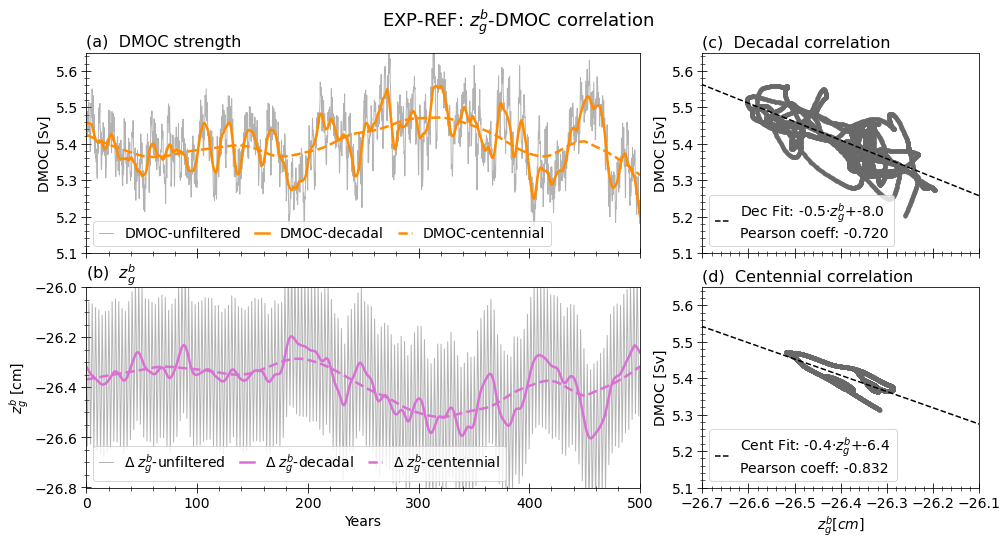

In [14]:
%matplotlib inline
gs_kw = dict(width_ratios=[2,1])
fig, ax = plt.subplots(2,2,figsize=(16,8), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

# gs = ax[0,0].get_gridspec()
# for a in ax[:,1]:
#     a.remove()
# axC = fig.add_subplot(gs[:2,1])
# axC1 = fig.add_subplot(gs[2:,1])
# for a in ax[:,0]:
#     a.remove()
# axt = fig.add_subplot(gs[:2,0])
# axT1 = fig.add_subplot(gs[2:,0])
years500=np.linspace(0,500,6000)
mean=12
zg_m = ds[exp0].zgDE.rolling({'t':mean}).mean('t')
zg_m_dec = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values*100,years500,frac=0.02))[1]
zg_m_dec1 = np.transpose(lowess(ds[exp0].zgDE.values*100,years500,frac=0.02))[1]
zg_m_cent = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values*100,years500,frac=0.2))[1]
zg_m_cent1 = np.transpose(lowess(ds[exp0].zgDE.values*100,years500,frac=0.2))[1]
t_dec,DMOC_dec = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.02))
t_cent,DMOC_cent = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.2))
lag=0
cut=slice(int(mean/2)+lag, -(int(mean/2)-1))
cut_r = slice(mean-1,None)

ax[0,0].plot(years500[::2],ds[exp0].psi_dmoc.values[::2],linewidth=1,c='dimgrey',linestyle='-', label='DMOC-unfiltered', alpha=0.5)
ax[0,0].plot(t_dec,DMOC_dec,linewidth=2.5,c='Darkorange', label='DMOC-decadal')
ax[0,0].plot(t_cent,DMOC_cent,linewidth=2.5,c='Darkorange', label='DMOC-centennial',linestyle='--')
ax[1,0].plot(years500[::9],(ds[exp0].zgDE-ds[exp0].zgDE_gm).values[::9]*100,linewidth=1,c='dimgrey',linestyle='-', label='$\Delta\; z_{g}^b$-unfiltered', alpha=0.5)
ax[1,0].plot(t_dec,zg_m_dec,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-decadal')
ax[1,0].plot(t_cent,zg_m_cent,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-centennial',linestyle='--')

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

ax[0,0].set_ylim(5.1,5.65)
ax[1,0].set_ylim(-26.8,-26)
#ax[1,0].set_yticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)

ax[0,0].set_xticklabels([])
ax[0,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1, columnspacing=1)
ax[1,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1, columnspacing=1)

lg_dec = stats.linregress(zg_m_dec, DMOC_dec)
lg_cent = stats.linregress(zg_m_cent, DMOC_cent)
pearson_dec = np.corrcoef(zg_m_dec,DMOC_dec)
pearson_cent = np.corrcoef(zg_m_cent,DMOC_cent)

lg_raw = stats.linregress(zg_m[cut_r], ds[exp0].psi_dmoc.values[cut])
ax[0,1].scatter(zg_m_dec,DMOC_dec,s=10,color='Dimgrey')
ax[1,1].scatter(zg_m_cent,DMOC_cent,s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec)-.1,
                    np.nanmax(zg_m_dec)+.1,100)
ax[0,1].plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
             label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_dec[0],lg_dec[1], pearson_dec[0,1]))
        #    label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_dec[0],lg_dec[1],lg_dec[2]**2, pearson_dec[0,1]))

ax[1,1].plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
             label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_cent[0],lg_cent[1], pearson_cent[0,1]))
           #label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_cent[0],lg_cent[1],lg_cent[2]**2, pearson_cent[0,1]))
#axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
#           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n p: %.3f'%(lg[0],lg[1],lg[2]**2,lg[3]))
#axbig.plot(x_const,lg_raw[0]*x_const+lg_raw[1],linewidth=1.5,c='k',linestyle='--',
#           label='LinReg2 r: %.3f \nLinReg2 p: %.3f'%(lg_raw[2]**2,lg_raw[3]))
# for axbig in ax[:,1]:
#     axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
#     axbig.set_ylabel('DMOC [Sv]',fontsize=14)
#     axbig.legend(fontsize=14,loc='lower left')
#     #axbig.set_xlim(-0.374,-0.3675)
#     #axbig.set_xticks([-0.374,-0.372,-0.37,-0.368])
#     #axbig.set_xticklabels([-37.4,-37.2,-37,-36.8])
#     axbig.set_title('(c)  $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)


ax[1,1].set_xlabel('$z_g^b [cm]$',fontsize=14)
ax[0,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(5.1,5.65)
ax[1,1].set_ylim(5.1,5.65)
ax[0,1].set_xlim(-26.7,-26.1)
ax[1,1].set_xlim(-26.7,-26.1)
#ax[1,1].set_xticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[1,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[0,0].set_title('(a)  DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)  $z_g^b$',fontsize=16, loc='left')#, x=-.1)
ax[0,1].set_title('(c)  Decadal correlation',fontsize=16, loc='left')#, x=-.1)
ax[1,1].set_title('(d)  Centennial correlation',fontsize=16, loc='left')#, x=-.1)

fig.suptitle('EXP-REF: $z_g^b$-DMOC correlation',fontsize=18,y=0.96)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
plt.savefig('figures/Fig6_GOCvsZG_REF.png', dpi=150, transparent=True, bbox_inches='tight')

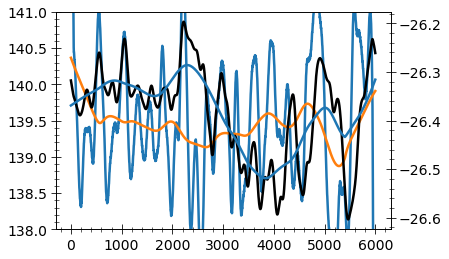

In [19]:
mld = properties['EXP00_1m500'].horizontal_mean(ds['EXP00_1m500'].mld)
years500=np.linspace(0,500,6000)
mld_dec = np.transpose(lowess(mld,years500,frac=0.02))[1]
mld_cent = np.transpose(lowess(mld,years500,frac=0.2))[1]
plt.plot(mld_dec[1:-1])
plt.plot(mld_cent)
plt.ylim(138,141)


ax1 = plt.twinx()
years500=np.linspace(0,500,6000)
zg_m_cent = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values*100,years500,frac=0.2))[1]
zg_m_dec = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values*100,years500,frac=0.02))[1]
ax1.plot(zg_m_dec,c='k')
ax1.plot(zg_m_cent)

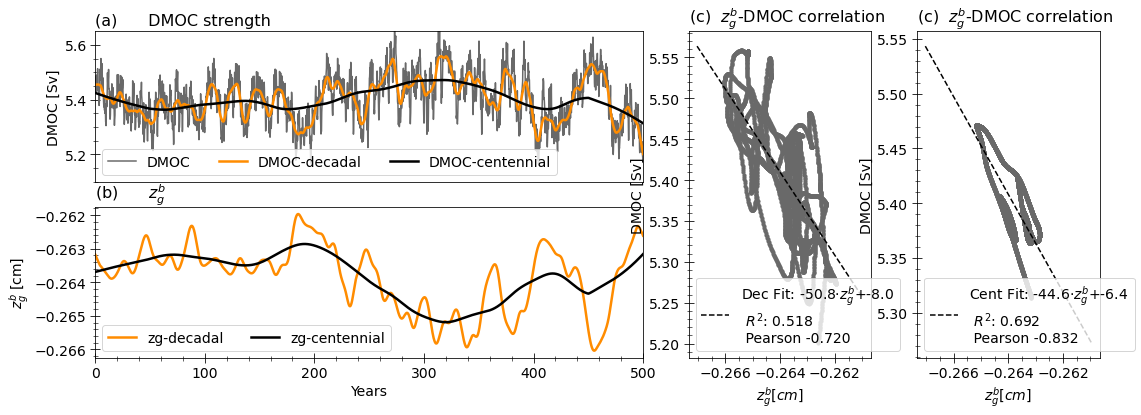

In [38]:
%matplotlib inline
gs_kw = dict(width_ratios=[3,1,1])
fig, ax = plt.subplots(2,3,figsize=(18,6), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

gs = ax[0,0].get_gridspec()
for a in ax[:,1]:
    a.remove()
axbig = fig.add_subplot(gs[:,1])
for a in ax[:,2]:
    a.remove()
axbig1 = fig.add_subplot(gs[:,2])

years500=np.linspace(0,500,6000)
mean=12
zg_m = ds[exp0].zgDE.rolling({'t':mean}).mean('t')
zg_m_dec = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values,years500,frac=0.02))[1]
zg_m_dec1 = np.transpose(lowess(ds[exp0].zgDE.values,years500,frac=0.02))[1]
zg_m_cent = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values,years500,frac=0.2))[1]
zg_m_cent1 = np.transpose(lowess(ds[exp0].zgDE.values,years500,frac=0.2))[1]
t_dec,DMOC_dec = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.02))
t_cent,DMOC_cent = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.2))
lag=0
cut=slice(int(mean/2)+lag, -(int(mean/2)-1))
cut_r = slice(mean-1,None)

ax[0,0].plot(years500[::2],ds[exp0].psi_dmoc.values[::2],
             linewidth=1.5,c='dimgrey',linestyle='-', label='DMOC')
ax[0,0].plot(t_dec,DMOC_dec,linewidth=2.5,c='Darkorange', label='DMOC-decadal')
ax[0,0].plot(t_cent,DMOC_cent,linewidth=2.5,c='k', label='DMOC-centennial')
ax[1,0].plot(t_dec,zg_m_dec,linewidth=2.5,c='Darkorange', label='zg-decadal')
#ax[1,0].plot(t_dec,zg_m_dec1,linewidth=2.5,c='green', label='zg-decadal')
ax[1,0].plot(t_cent,zg_m_cent,linewidth=2.5,c='k', label='zg-centennial')
#ax[1,0].plot(years500[cut_r],zg_m[cut_r], label='$<z_g^b>_{t(1y)}$')
#ax[1,0].plot(years500[cut_r],zg_m1[cut_r])
#ax[1,0].plot(years500[cut_r],zg_m2[cut_r])

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

#ax[0,0].set_ylim(5.95,6.55)
#ax[0,0].set_yticklabels([6,6.1,6.2,6.3,6.4,6.5])
#ax[0,0].set_yticklabels([5.9,6.0,6.1,6.2,6.3,6.4,6.5])

ax[0,0].set_ylim(5.1,5.65)
#ax[1,0].set_ylim(-0.374,-0.3675)
#ax[1,0].set_ylim(-0.375,-0.368)
#ax[1,0].set_yticks([-0.374,-0.372,-0.37])
#ax[1,0].set_yticklabels([-37.4,-37.2,-37])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)
#ax[1,0].set_xticks([0,600,1200,1800,2400])
#ax[1,0].set_xticklabels([0,50,100,150,200])

ax[0,0].set_xticks([])
ax[0,0].legend(fontsize=14,loc='lower left',ncol=3)
ax[1,0].legend(fontsize=14,loc='lower left',ncol=2)
#ax[0,0].set_xticks([0,600,1200,1800,2400])
#ax[0,0].set_xticklabels([])

lg_dec = stats.linregress(zg_m_dec, DMOC_dec)
lg_cent = stats.linregress(zg_m_cent, DMOC_cent)
pearson_dec = np.corrcoef(zg_m_dec,DMOC_dec)
pearson_cent = np.corrcoef(zg_m_cent,DMOC_cent)

lg_raw = stats.linregress(zg_m[cut_r], ds[exp0].psi_dmoc.values[cut])
axbig.scatter(zg_m_dec,DMOC_dec,s=10,color='Dimgrey')
axbig1.scatter(zg_m_cent,DMOC_cent,s=10,color='Dimgrey')
#axbig.scatter(zg_m[cut],ds[sim[0]].psi_dmoc.values[cut],s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec)-.001,
                    np.nanmax(zg_m_dec)+.001,100)
axbig.plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
           label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_dec[0],lg_dec[1],lg_dec[2]**2, pearson_dec[0,1]))

axbig1.plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
           label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_cent[0],lg_cent[1],lg_cent[2]**2, pearson_cent[0,1]))
#axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
#           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n p: %.3f'%(lg[0],lg[1],lg[2]**2,lg[3]))
#axbig.plot(x_const,lg_raw[0]*x_const+lg_raw[1],linewidth=1.5,c='k',linestyle='--',
#           label='LinReg2 r: %.3f \nLinReg2 p: %.3f'%(lg_raw[2]**2,lg_raw[3]))
for axbig in [axbig, axbig1]:
    axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
    axbig.set_ylabel('DMOC [Sv]',fontsize=14)
    axbig.legend(fontsize=14,loc='lower left')
    #axbig.set_xlim(-0.374,-0.3675)
    #axbig.set_xticks([-0.374,-0.372,-0.37,-0.368])
    #axbig.set_xticklabels([-37.4,-37.2,-37,-36.8])
    axbig.set_title('(c)  $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)

ax[0,0].set_title('(a)      DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)      $z_g^b$',fontsize=16, loc='left')#, x=-.1)

#fig.suptitle('General overturning circulation strength',fontsize=18,y=0.94)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
#plt.savefig('Figures/Fig4_GOCvsZG_REF.png', dpi=150, transparent=True, bbox_inches='tight')

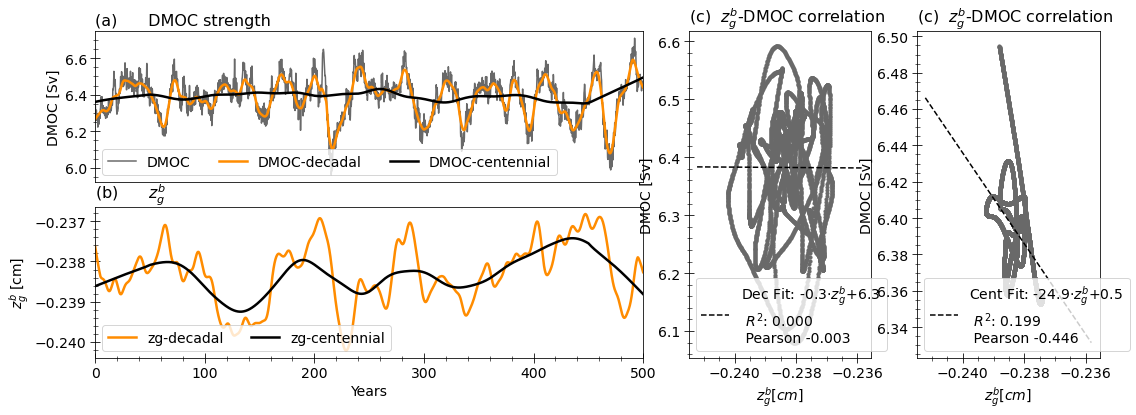

In [40]:
%matplotlib inline
gs_kw = dict(width_ratios=[3,1,1])
fig, ax = plt.subplots(2,3,figsize=(18,6), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

gs = ax[0,0].get_gridspec()
for a in ax[:,1]:
    a.remove()
axbig = fig.add_subplot(gs[:,1])
for a in ax[:,2]:
    a.remove()
axbig1 = fig.add_subplot(gs[:,2])

years500=np.linspace(0,500,6000)
mean=12
zg_m = ds[exp1].zgDE.rolling({'t':mean}).mean('t')
zg_m_dec = np.transpose(lowess((ds[exp1].zgDE-ds[exp1].zgDE_gm).values,years500,frac=0.02))[1]
zg_m_dec1 = np.transpose(lowess(ds[exp1].zgDE.values,years500,frac=0.02))[1]
zg_m_cent = np.transpose(lowess((ds[exp1].zgDE-ds[exp1].zgDE_gm).values,years500,frac=0.2))[1]
zg_m_cent1 = np.transpose(lowess(ds[exp1].zgDE.values,years500,frac=0.2))[1]
t_dec,DMOC_dec = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.02))
t_cent,DMOC_cent = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.2))
lag=0
cut=slice(int(mean/2)+lag, -(int(mean/2)-1))
cut_r = slice(mean-1,None)

ax[0,0].plot(years500[::2],ds[exp1].psi_dmoc.values[::2],
             linewidth=1.5,c='dimgrey',linestyle='-', label='DMOC')
ax[0,0].plot(t_dec,DMOC_dec,linewidth=2.5,c='Darkorange', label='DMOC-decadal')
ax[0,0].plot(t_cent,DMOC_cent,linewidth=2.5,c='k', label='DMOC-centennial')
ax[1,0].plot(t_dec,zg_m_dec,linewidth=2.5,c='Darkorange', label='zg-decadal')
#ax[1,0].plot(t_dec,zg_m_dec1,linewidth=2.5,c='green', label='zg-decadal')
ax[1,0].plot(t_cent,zg_m_cent,linewidth=2.5,c='k', label='zg-centennial')
#ax[1,0].plot(years500[cut_r],zg_m[cut_r], label='$<z_g^b>_{t(1y)}$')
#ax[1,0].plot(years500[cut_r],zg_m1[cut_r])
#ax[1,0].plot(years500[cut_r],zg_m2[cut_r])

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

#ax[0,0].set_ylim(5.95,6.55)
#ax[0,0].set_yticklabels([6,6.1,6.2,6.3,6.4,6.5])
#ax[0,0].set_yticklabels([5.9,6.0,6.1,6.2,6.3,6.4,6.5])

#ax[0,0].set_ylim(5.1,5.65)
#ax[1,0].set_ylim(-0.374,-0.3675)
#ax[1,0].set_ylim(-0.375,-0.368)
#ax[1,0].set_yticks([-0.374,-0.372,-0.37])
#ax[1,0].set_yticklabels([-37.4,-37.2,-37])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)
#ax[1,0].set_xticks([0,600,1200,1800,2400])
#ax[1,0].set_xticklabels([0,50,100,150,200])

ax[0,0].set_xticks([])
ax[0,0].legend(fontsize=14,loc='lower left',ncol=3)
ax[1,0].legend(fontsize=14,loc='lower left',ncol=2)
#ax[0,0].set_xticks([0,600,1200,1800,2400])
#ax[0,0].set_xticklabels([])

lg_dec = stats.linregress(zg_m_dec, DMOC_dec)
lg_cent = stats.linregress(zg_m_cent, DMOC_cent)
pearson_dec = np.corrcoef(zg_m_dec,DMOC_dec)
pearson_cent = np.corrcoef(zg_m_cent,DMOC_cent)

lg_raw = stats.linregress(zg_m[cut_r], ds[exp1].psi_dmoc.values[cut])
axbig.scatter(zg_m_dec,DMOC_dec,s=10,color='Dimgrey')
axbig1.scatter(zg_m_cent,DMOC_cent,s=10,color='Dimgrey')
#axbig.scatter(zg_m[cut],ds[sim[0]].psi_dmoc.values[cut],s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec)-.001,
                    np.nanmax(zg_m_dec)+.001,100)
axbig.plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
           label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_dec[0],lg_dec[1],lg_dec[2]**2, pearson_dec[0,1]))

axbig1.plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
           label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_cent[0],lg_cent[1],lg_cent[2]**2, pearson_cent[0,1]))
#axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
#           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n p: %.3f'%(lg[0],lg[1],lg[2]**2,lg[3]))
#axbig.plot(x_const,lg_raw[0]*x_const+lg_raw[1],linewidth=1.5,c='k',linestyle='--',
#           label='LinReg2 r: %.3f \nLinReg2 p: %.3f'%(lg_raw[2]**2,lg_raw[3]))
for axbig in [axbig, axbig1]:
    axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
    axbig.set_ylabel('DMOC [Sv]',fontsize=14)
    axbig.legend(fontsize=14,loc='lower left')
    #axbig.set_xlim(-0.374,-0.3675)
    #axbig.set_xticks([-0.374,-0.372,-0.37,-0.368])
    #axbig.set_xticklabels([-37.4,-37.2,-37,-36.8])
    axbig.set_title('(c)  $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)

ax[0,0].set_title('(a)      DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)      $z_g^b$',fontsize=16, loc='left')#, x=-.1)

#fig.suptitle('General overturning circulation strength',fontsize=18,y=0.94)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
#plt.savefig('Figures/Fig4_GOCvsZG_REF.png', dpi=150, transparent=True, bbox_inches='tight')

[[ 1.         -0.44147397]
 [-0.44147397  1.        ]]


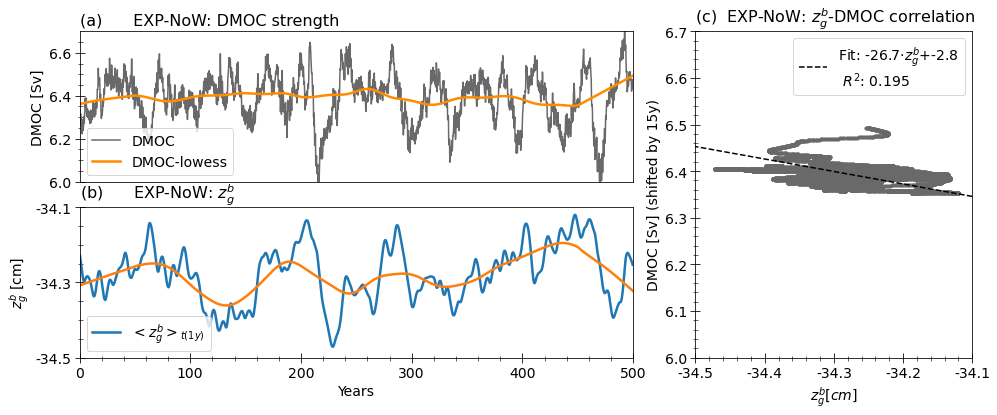

In [16]:
%matplotlib inline
gs_kw = dict(width_ratios=[2,1])
fig, ax = plt.subplots(2,2,figsize=(16,6), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

gs = ax[0,0].get_gridspec()
for a in ax[:,1]:
    a.remove()
axbig = fig.add_subplot(gs[:,1])

years500=np.linspace(0,500,6000)
mean=12
zg_m = ds[exp1].zgDE.rolling({'t':mean}).mean('t')
y_m = ds[exp1].zgDE.copy(data=years500).rolling({'t':mean}).mean('t')
t_lowess1,zg_m1 = np.transpose(lowess(ds[exp1].zgDE.values,years500,frac=0.2))
t_lowess,DMOC = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.2))

lag=0*12
cut=slice(int(mean/2)+lag, -(int(mean/2)-1))
#cut_r = slice(mean-1,-(lag))
cut_r = slice(mean-1,None)

ax[0,0].plot(years500[::2],ds[exp1].psi_dmoc.values[::2],
             linewidth=1.5,c='dimgrey',linestyle='-', label='DMOC')
ax[0,0].plot(t_lowess,DMOC,linewidth=2.5,c='Darkorange', label='DMOC-lowess')
ax[1,0].plot(y_m,zg_m, label='$<z_g^b>_{t(1y)}$')
ax[1,0].plot(t_lowess1,zg_m1)

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

ax[0,0].set_ylim(6.0,6.7)
ax[1,0].set_ylim(-0.345,-0.341)
ax[1,0].set_yticks([-0.345,-0.343,-0.341])
ax[1,0].set_yticklabels([-34.5,-34.3,-34.1])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)

ax[0,0].set_xticks([])
ax[0,0].legend(fontsize=14,loc='lower left')
ax[1,0].legend(fontsize=14,loc='lower left')
#ax[0,0].set_xticks([0,600,1200,1800,2400])
#ax[0,0].set_xticklabels([])

lg = stats.linregress(zg_m1, DMOC)#stats.linregress(zg_m[cut_r], DMOC[cut])
pearson = np.corrcoef(zg_m1,DMOC)
print(pearson)
lg_raw = stats.linregress(zg_m[cut_r], ds[exp1].psi_dmoc.values[cut])
axbig.scatter(zg_m[cut_r],DMOC[cut],s=10,color='Dimgrey')
#axbig.scatter(zg_m[cut],ds[sim[0]].psi_dmoc.values[cut],s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m)-.001,
                    np.nanmax(zg_m)+.001,100)

axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f'%(lg[0],lg[1],lg[2]**2))
#axbig.plot(x_const,lg[0]*x_const+lg[1],linewidth=1.5,c='k',linestyle='--',
#           label='Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n p: %.3f'%(lg[0],lg[1],lg[2]**2,lg[3]))
#axbig.plot(x_const,lg_raw[0]*x_const+lg_raw[1],linewidth=1.5,c='k',linestyle='--',
#           label='LinReg2 r: %.3f \nLinReg2 p: %.3f'%(lg_raw[2]**2,lg_raw[3]))

axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
axbig.set_ylabel('DMOC [Sv] (shifted by 15y)',fontsize=14)
axbig.legend(fontsize=14)
axbig.set_ylim(6.0,6.7)
axbig.set_xlim(-0.345,-0.341)
axbig.set_xticks([-0.345,-0.344,-0.343,-0.342,-0.341])
axbig.set_xticklabels([-34.5,-34.4,-34.3,-34.2,-34.1])

ax[0,0].set_title('(a)      EXP-NoW: DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)      EXP-NoW: $z_g^b$',fontsize=16, loc='left')#, x=-.1)
axbig.set_title('(c)  EXP-NoW: $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)
#fig.suptitle('General overturning circulation strength',fontsize=18,y=0.94)
ax[0,0].arrow(325,7.045,30,0,width=0.04, head_length=7,facecolor='darkgrey')
ax[0,0].annotate('~ 15y lag',(250,7.025),fontsize=14)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
#plt.savefig('Figures/Fig4_GOCvsZG_NOWIND.png', dpi=150, transparent=True, bbox_inches='tight')

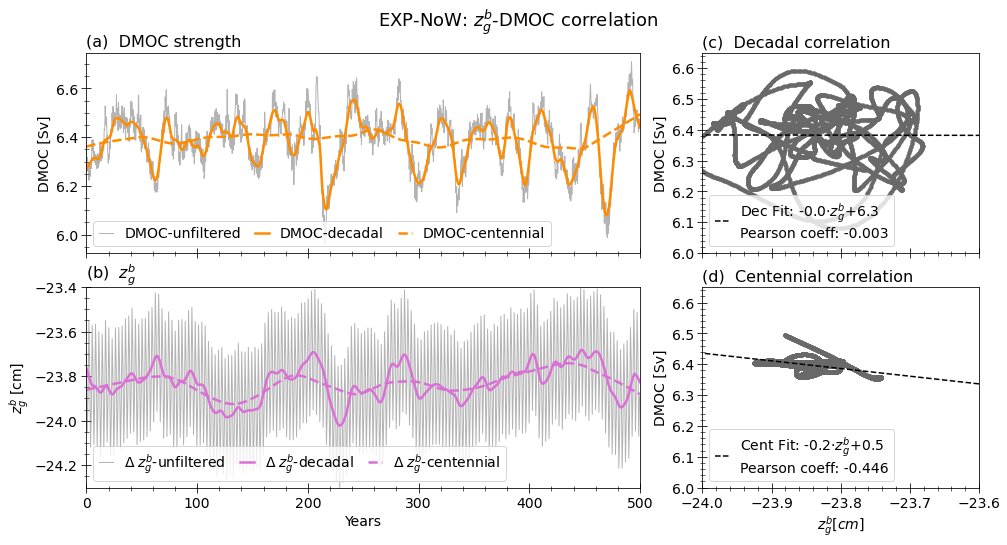

In [15]:
%matplotlib inline
gs_kw = dict(width_ratios=[2,1])
fig, ax = plt.subplots(2,2,figsize=(16,8), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

# gs = ax[0,0].get_gridspec()
# for a in ax[:,1]:
#     a.remove()
# axC = fig.add_subplot(gs[:2,1])
# axC1 = fig.add_subplot(gs[2:,1])
# for a in ax[:,0]:
#     a.remove()
# axt = fig.add_subplot(gs[:2,0])
# axT1 = fig.add_subplot(gs[2:,0])
years500=np.linspace(0,500,6000)
mean=12
zg_m = ds[exp1].zgDE.rolling({'t':mean}).mean('t')
zg_m_dec = np.transpose(lowess((ds[exp1].zgDE-ds[exp1].zgDE_gm).values*100,years500,frac=0.02))[1]
zg_m_dec1 = np.transpose(lowess(ds[exp1].zgDE.values*100,years500,frac=0.02))[1]
zg_m_cent = np.transpose(lowess((ds[exp1].zgDE-ds[exp1].zgDE_gm).values*100,years500,frac=0.2))[1]
zg_m_cent1 = np.transpose(lowess(ds[exp1].zgDE.values*100,years500,frac=0.2))[1]
t_dec,DMOC_dec = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.02))
t_cent,DMOC_cent = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.2))
lag=0
cut=slice(int(mean/2)+lag, -(int(mean/2)-1))
cut_r = slice(mean-1,None)

ax[0,0].plot(years500[::2],ds[exp1].psi_dmoc.values[::2],linewidth=1,c='dimgrey',linestyle='-', label='DMOC-unfiltered', alpha=0.5)
ax[0,0].plot(t_dec,DMOC_dec,linewidth=2.5,c='Darkorange', label='DMOC-decadal')
ax[0,0].plot(t_cent,DMOC_cent,linewidth=2.5,c='Darkorange', label='DMOC-centennial',linestyle='--')
ax[1,0].plot(years500[::9],(ds[exp1].zgDE-ds[exp1].zgDE_gm).values[::9]*100,linewidth=1,c='dimgrey',linestyle='-', label='$\Delta\; z_{g}^b$-unfiltered', alpha=0.5)
ax[1,0].plot(t_dec,zg_m_dec,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-decadal')
ax[1,0].plot(t_cent,zg_m_cent,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-centennial',linestyle='--')

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

#ax[0,0].set_ylim(5.1,5.65)
ax[1,0].set_ylim(-24.3,-23.4)
#ax[1,0].set_yticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)

ax[0,0].set_xticklabels([])
ax[0,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1, columnspacing=1)
ax[1,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1, columnspacing=1)

lg_dec = stats.linregress(zg_m_dec, DMOC_dec)
lg_cent = stats.linregress(zg_m_cent, DMOC_cent)
pearson_dec = np.corrcoef(zg_m_dec,DMOC_dec)
pearson_cent = np.corrcoef(zg_m_cent,DMOC_cent)

ax[0,1].scatter(zg_m_dec,DMOC_dec,s=10,color='Dimgrey')
ax[1,1].scatter(zg_m_cent,DMOC_cent,s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec)-.1,
                    np.nanmax(zg_m_dec)+.1,100)
ax[0,1].plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
             label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_dec[0],lg_dec[1], pearson_dec[0,1]))
        #    label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_dec[0],lg_dec[1],lg_dec[2]**2, pearson_dec[0,1]))

ax[1,1].plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
             label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_cent[0],lg_cent[1], pearson_cent[0,1]))
           #label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_cent[0],lg_cent[1],lg_cent[2]**2, pearson_cent[0,1]))
# for axbig in ax[:,1]:
#     axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
#     axbig.set_ylabel('DMOC [Sv]',fontsize=14)
#     axbig.legend(fontsize=14,loc='lower left')
#     #axbig.set_xlim(-0.374,-0.3675)
#     #axbig.set_xticks([-0.374,-0.372,-0.37,-0.368])
#     #axbig.set_xticklabels([-37.4,-37.2,-37,-36.8])
#     axbig.set_title('(c)  $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)


ax[1,1].set_xlabel('$z_g^b [cm]$',fontsize=14)
ax[0,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(6.0,6.65)
ax[1,1].set_ylim(6.0,6.65)
ax[0,1].set_xlim(-24,-23.6)
ax[1,1].set_xlim(-24,-23.6)
#ax[1,1].set_xticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[1,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[0,0].set_title('(a)  DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)  $z_g^b$',fontsize=16, loc='left')#, x=-.1)
ax[0,1].set_title('(c)  Decadal correlation',fontsize=16, loc='left')#, x=-.1)
ax[1,1].set_title('(d)  Centennial correlation',fontsize=16, loc='left')#, x=-.1)

fig.suptitle('EXP-NoW: $z_g^b$-DMOC correlation',fontsize=18,y=0.96)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
plt.savefig('figures/Fig6_GOCvsZG_NOW.png', dpi=150, transparent=True, bbox_inches='tight')

In [67]:
zg_m_dec = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values*100,years500,frac=0.02))[1]
t_dec,DMOC_dec = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.02))
for shift in range(0,12*30,24):
    #lg_dec = stats.linregress(zg_m_dec[], DMOC_dec)
    if shift==0:
        pearson_dec = np.corrcoef(zg_m_dec,DMOC_dec)
    else:
        pearson_dec = np.corrcoef(zg_m_dec[:-shift],DMOC_dec[shift:])
    print('Timeshift %i: %.3f'%(shift/12,pearson_dec[0,1]))

Timeshift 0: -0.720
Timeshift 2: -0.693
Timeshift 4: -0.641
Timeshift 6: -0.566
Timeshift 8: -0.473
Timeshift 10: -0.371
Timeshift 12: -0.272
Timeshift 14: -0.184
Timeshift 16: -0.114
Timeshift 18: -0.063
Timeshift 20: -0.032
Timeshift 22: -0.018
Timeshift 24: -0.016
Timeshift 26: -0.021
Timeshift 28: -0.026


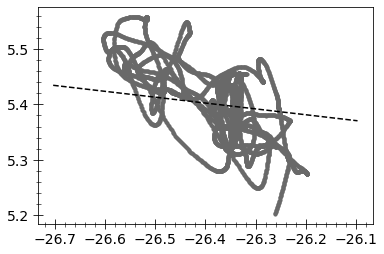

In [69]:
shift=15*12
lg_dec = stats.linregress(zg_m_dec[:-shift], DMOC_dec[shift:])
pearson_dec = np.corrcoef(zg_m_dec[:-shift],DMOC_dec[shift:])
        
plt.scatter(zg_m_dec,DMOC_dec,s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec)-.1,
                    np.nanmax(zg_m_dec)+.1,100)
plt.plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
             label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \nPearson %.3f'%(lg_dec[0],lg_dec[1], pearson_dec[0,1]))

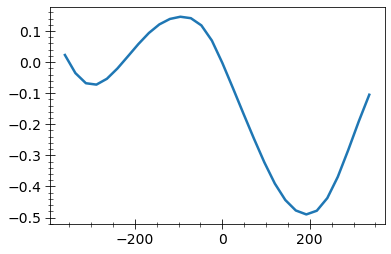

In [104]:
plt.plot(timeshift, pearson_dec)

In [70]:
zg_m_cent = np.transpose(lowess((ds[exp1].zgDE-ds[exp1].zgDE_gm).values*100,years500,frac=0.2))[1]
t_cent,DMOC_cent = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.2))
for shift in range(0,12*30,24):
    #lg_dec = stats.linregress(zg_m_dec[], DMOC_dec)
    if shift==0:
        pearson_cent = np.corrcoef(zg_m_cent,DMOC_cent)
    else:
        pearson_cent = np.corrcoef(zg_m_cent[:-shift],DMOC_cent[shift:])

    print('Timeshift %i: %.3f'%(shift/12,pearson_cent[0,1]))
# plt.scatter(zg_m_cent,DMOC_cent,s=10,color='Dimgrey')
# x_const=np.linspace(np.nanmin(zg_m_dec)-.1,
#                     np.nanmax(zg_m_dec)+.1,100)

# plt.plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
#              label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \nPearson %.3f'%(lg_cent[0],lg_cent[1], pearson_cent[0,1]))

Timeshift 0: -0.446
Timeshift 2: -0.450
Timeshift 4: -0.453
Timeshift 6: -0.453
Timeshift 8: -0.451
Timeshift 10: -0.446
Timeshift 12: -0.438
Timeshift 14: -0.427
Timeshift 16: -0.412
Timeshift 18: -0.395
Timeshift 20: -0.374
Timeshift 22: -0.350
Timeshift 24: -0.324
Timeshift 26: -0.294
Timeshift 28: -0.263


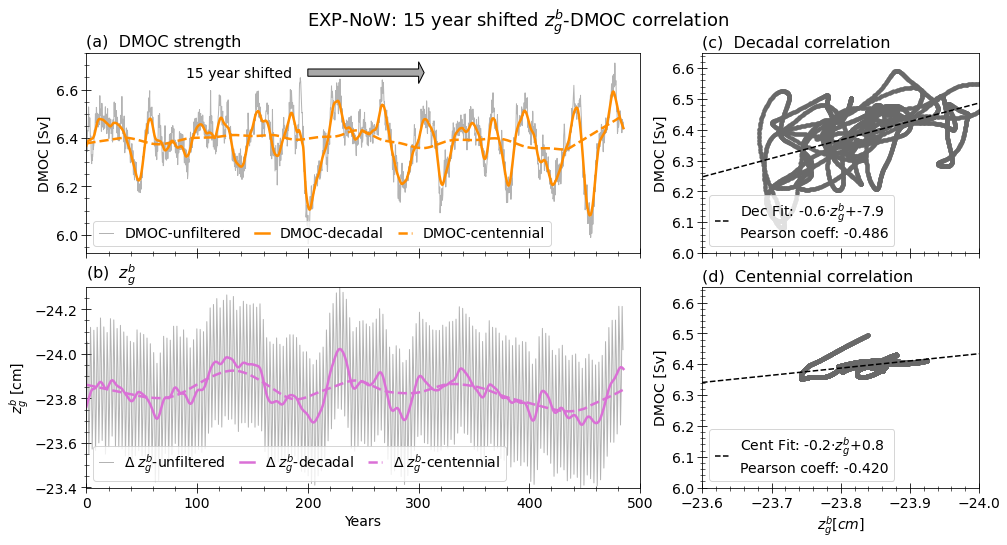

In [112]:
%matplotlib inline
gs_kw = dict(width_ratios=[2,1])
fig, ax = plt.subplots(2,2,figsize=(16,8), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

ex = exp1
years500=np.linspace(0,500,6000)
shift=15*12
t_decz,zg_m_dec = np.transpose(lowess((ds[ex].zgDE-ds[ex].zgDE_gm).values*100,years500,frac=0.02))
t_centz,zg_m_cent = np.transpose(lowess((ds[ex].zgDE-ds[ex].zgDE_gm).values*100,years500,frac=0.2))
t_dec,DMOC_dec = np.transpose(lowess(ds[ex].psi_dmoc.values,years500,frac=0.02))
t_cent,DMOC_cent = np.transpose(lowess(ds[ex].psi_dmoc.values,years500,frac=0.2))
t_dec, t_cent, DMOC_dec, DMOC_cent = t_dec[:-shift], t_cent[:-shift], DMOC_dec[shift:], DMOC_cent[shift:]
t_decz, t_centz, zg_m_dec, zg_m_cent = t_decz[:-shift], t_centz[:-shift], zg_m_dec[:-shift], zg_m_cent[:-shift]
# t_dec, t_cent, DMOC_dec, DMOC_cent = t_dec[:-shift], t_cent[:-shift], DMOC_dec[:-shift], DMOC_cent[:-shift]
# t_decz, t_centz, zg_m_dec, zg_m_cent = t_decz[shift:], t_centz[shift:], zg_m_dec[shift:], zg_m_cent[shift:]

ax[0,0].plot(years500[:-shift:2],ds[ex].psi_dmoc.values[shift::2],linewidth=1,c='dimgrey',linestyle='-', label='DMOC-unfiltered', alpha=0.5)
ax[0,0].plot(t_dec,DMOC_dec,linewidth=2.5,c='Darkorange', label='DMOC-decadal')
ax[0,0].plot(t_cent,DMOC_cent,linewidth=2.5,c='Darkorange', label='DMOC-centennial',linestyle='--')
ax[1,0].plot(years500[:-shift:9],(ds[ex].zgDE-ds[ex].zgDE_gm).values[:-shift:9]*100,linewidth=1,c='dimgrey',linestyle='-', label='$\Delta\; z_{g}^b$-unfiltered', alpha=0.5)
ax[1,0].plot(t_decz,zg_m_dec,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-decadal')
ax[1,0].plot(t_centz,zg_m_cent,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-centennial',linestyle='--')

ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

#ax[0,0].set_ylim(5.1,5.65)
ax[1,0].set_ylim(-23.4,-24.3)
#ax[1,0].set_yticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)

ax[0,0].set_xticklabels([])
ax[0,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1, columnspacing=1)
ax[1,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1, columnspacing=1)

lg_dec = stats.linregress(zg_m_dec, DMOC_dec)
lg_cent = stats.linregress(zg_m_cent, DMOC_cent)
pearson_dec = np.corrcoef(zg_m_dec,DMOC_dec)
pearson_cent = np.corrcoef(zg_m_cent,DMOC_cent)

ax[0,1].scatter(zg_m_dec,DMOC_dec,s=10,color='Dimgrey')
ax[1,1].scatter(zg_m_cent,DMOC_cent,s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec)-.1,
                    np.nanmax(zg_m_dec)+.1,100)
ax[0,1].plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
             label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_dec[0],lg_dec[1], pearson_dec[0,1]))
        #    label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_dec[0],lg_dec[1],lg_dec[2]**2, pearson_dec[0,1]))

ax[1,1].plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
             label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_cent[0],lg_cent[1], pearson_cent[0,1]))
           #label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_cent[0],lg_cent[1],lg_cent[2]**2, pearson_cent[0,1]))
# for axbig in ax[:,1]:
#     axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
#     axbig.set_ylabel('DMOC [Sv]',fontsize=14)
#     axbig.legend(fontsize=14,loc='lower left')
#     #axbig.set_xlim(-0.374,-0.3675)
#     #axbig.set_xticks([-0.374,-0.372,-0.37,-0.368])
#     #axbig.set_xticklabels([-37.4,-37.2,-37,-36.8])
#     axbig.set_title('(c)  $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)


ax[1,1].set_xlabel('$z_g^b [cm]$',fontsize=14)
ax[0,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(6.0,6.65)
ax[1,1].set_ylim(6.0,6.65)
ax[0,1].set_xlim(-23.6,-24)
ax[1,1].set_xlim(-23.6,-24)
#ax[1,1].set_xticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[1,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[0,0].set_title('(a)  DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)  $z_g^b$',fontsize=16, loc='left')#, x=-.1)
ax[0,1].set_title('(c)  Decadal correlation',fontsize=16, loc='left')#, x=-.1)
ax[1,1].set_title('(d)  Centennial correlation',fontsize=16, loc='left')#, x=-.1)

ax[0,0].arrow(200,6.67,100,0,width=0.03, head_length=5,facecolor='darkgrey')
ax[0,0].annotate('15 year shifted',(90,6.65),fontsize=14)

fig.suptitle('EXP-NoW: 15 year shifted $z_g^b$-DMOC correlation',fontsize=18,y=0.96)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
#plt.savefig('figures/Fig6_GOCvsZG_NOW_shifted.png', dpi=150, transparent=True, bbox_inches='tight')

(-23.6, -24.0)

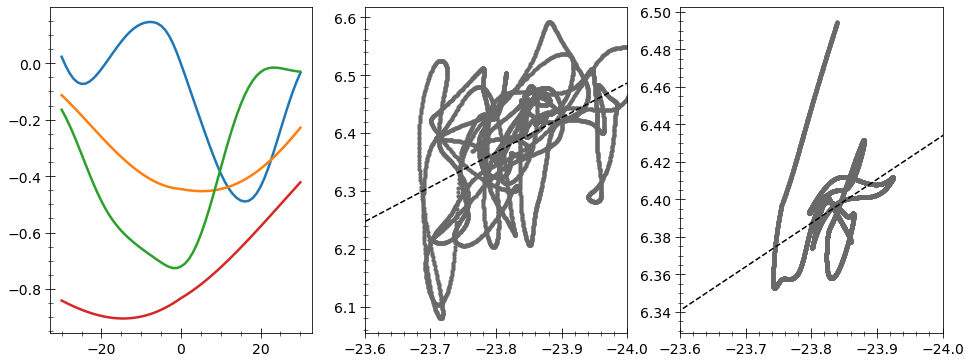

In [54]:
zg_m_dec0 = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values*100,years500,frac=0.02))[1]
t_dec00,DMOC_dec0 = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.02))
zg_m_cent0 = np.transpose(lowess((ds[exp0].zgDE-ds[exp0].zgDE_gm).values*100,years500,frac=0.2))[1]
t_cent0,DMOC_cent0 = np.transpose(lowess(ds[exp0].psi_dmoc.values,years500,frac=0.2))
pearson_dec0_list=[]
pearson_cent0_list=[]
timeshift=[]
for shift in range(-12*30,12*30+12,12):
    timeshift.append(shift)
    if shift==0:
        pearson_dec0_list.append(np.corrcoef(zg_m_dec0,DMOC_dec0)[0,1])
        pearson_cent0_list.append(np.corrcoef(zg_m_cent0,DMOC_cent0)[0,1])
    elif shift>0:   
        pearson_dec0_list.append(np.corrcoef(zg_m_dec0[:-shift],DMOC_dec0[shift:])[0,1])
        pearson_cent0_list.append(np.corrcoef(zg_m_cent0[:-shift],DMOC_cent0[shift:])[0,1])
    else:
        pearson_dec0_list.append(np.corrcoef(zg_m_dec0[-shift:],DMOC_dec0[:shift])[0,1])
        pearson_cent0_list.append(np.corrcoef(zg_m_cent0[-shift:],DMOC_cent0[:shift])[0,1])
#     print('Timeshift %i: %.3f'%(shift/12,pearson_dec[-1]))
        
zg_m_dec = np.transpose(lowess((ds[exp1].zgDE-ds[exp1].zgDE_gm).values*100,years500,frac=0.02))[1]
t_dec,DMOC_dec = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.02))
zg_m_cent = np.transpose(lowess((ds[exp1].zgDE-ds[exp1].zgDE_gm).values*100,years500,frac=0.2))[1]
t_cent,DMOC_cent = np.transpose(lowess(ds[exp1].psi_dmoc.values,years500,frac=0.2))
pearson_dec_list=[]
pearson_cent_list=[]
timeshift=[]
for shift in range(-12*30,12*30+12,12):
    timeshift.append(shift)
    if shift==0:
        pearson_dec_list.append(np.corrcoef(zg_m_dec,DMOC_dec)[0,1])
        pearson_cent_list.append(np.corrcoef(zg_m_cent,DMOC_cent)[0,1])
    elif shift>0:   
        pearson_dec_list.append(np.corrcoef(zg_m_dec[:-shift],DMOC_dec[shift:])[0,1])
        pearson_cent_list.append(np.corrcoef(zg_m_cent[:-shift],DMOC_cent[shift:])[0,1])
    else:
        pearson_dec_list.append(np.corrcoef(zg_m_dec[-shift:],DMOC_dec[:shift])[0,1])
        pearson_cent_list.append(np.corrcoef(zg_m_cent[-shift:],DMOC_cent[:shift])[0,1])
#     print('Timeshift %i: %.3f'%(shift/12,pearson_dec[-1]))
        
fig,ax = plt.subplots(1,3,figsize=(16,6))
timeshift = np.array(timeshift)
ax[0].plot(timeshift/12, pearson_dec_list)
ax[0].plot(timeshift/12, pearson_cent_list)
ax[0].plot(timeshift/12, pearson_dec0_list)
ax[0].plot(timeshift/12, pearson_cent0_list)


shift=15*12
lg_dec = stats.linregress(zg_m_dec[:-shift], DMOC_dec[shift:])
lg_cent = stats.linregress(zg_m_cent[:-shift], DMOC_cent[shift:])
pearson_dec_max = np.corrcoef(zg_m_dec[:-shift],DMOC_dec[shift:])
pearson_cent_max = np.corrcoef(zg_m_cent[:-shift],DMOC_cent[shift:])

ax[1].scatter(zg_m_dec[:-shift],DMOC_dec[shift:],s=10,color='Dimgrey')
ax[2].scatter(zg_m_cent[:-shift],DMOC_cent[shift:],s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec)-.1,
                    np.nanmax(zg_m_dec)+.1,100)
ax[1].plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
             label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_dec[0],lg_dec[1], pearson_dec_max[0,1]))
        #    label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_dec[0],lg_dec[1],lg_dec[2]**2, pearson_dec[0,1]))

ax[2].plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
             label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_cent[0],lg_cent[1], pearson_cent_max[0,1]))

ax[1].set_xlim(-23.6,-24)
ax[2].set_xlim(-23.6,-24)

Text(0.5, 0.98, 'DMOC-$\\Delta\\; z_{g}^b$ timeshifted correlation')

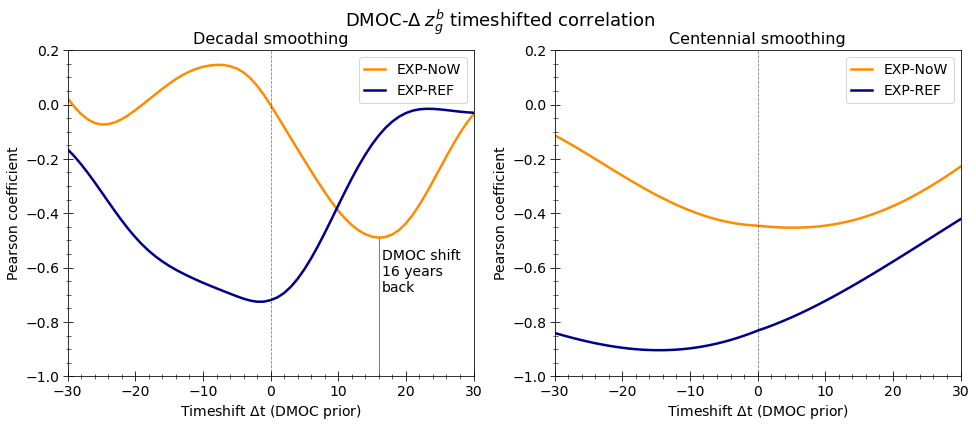

In [61]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
timeshift = np.array(timeshift)
ax[0].plot(timeshift/12, pearson_dec_list,linewidth=2.5,c='Darkorange', label='EXP-NoW')
ax[0].plot(timeshift/12, pearson_dec0_list,linewidth=2.5,c='darkblue', label='EXP-REF')
ax[1].plot(timeshift/12, pearson_cent_list,linewidth=2.5,c='Darkorange', label='EXP-NoW')
ax[1].plot(timeshift/12, pearson_cent0_list,linewidth=2.5,c='darkblue', label='EXP-REF')
ax[0].vlines(0,-1,0.2,linewidth=0.8,linestyle='--',color='k',alpha=0.5)
ax[1].vlines(0,-1,0.2,linewidth=0.8,linestyle='--',color='k',alpha=0.5)
ax[0].vlines(16,-1,pearson_dec_list[46],linewidth=1,color='k',alpha=0.5)
ax[0].annotate('DMOC shift\n16 years\nback',(16.5,pearson_dec_list[46]-0.2),fontsize=14)

for a in ax:
    a.set_xlim(-30,30)
    a.set_ylim(-1,0.2)
    a.set_xlabel('Timeshift $\Delta$t (DMOC prior)',fontsize=14)
    a.set_ylabel('Pearson coefficient',fontsize=14)
    a.legend(fontsize=14,loc='upper right',handlelength=1.5)
ax[0].set_title('Decadal smoothing',fontsize=16)
ax[1].set_title('Centennial smoothing',fontsize=16)
plt.suptitle('DMOC-$\Delta\; z_{g}^b$ timeshifted correlation',fontsize=18,y=0.98)
#plt.savefig('figures/Supplement_DMOC_zg_timeshift.png', dpi=150, transparent=True, bbox_inches='tight')

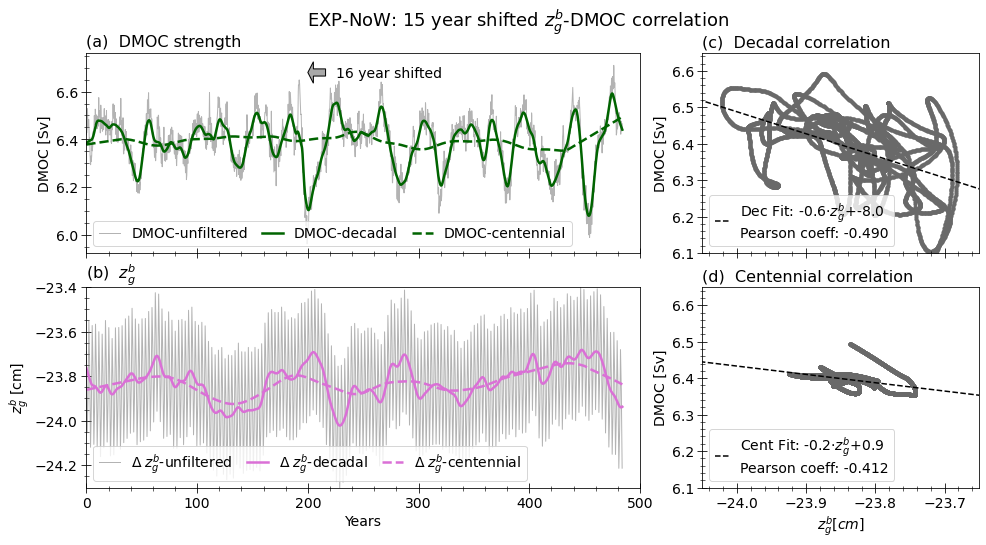

In [52]:
%matplotlib inline
gs_kw = dict(width_ratios=[2,1])
fig, ax = plt.subplots(2,2,figsize=(16,8), gridspec_kw=gs_kw)#,constrained_layout=True)#, gridspec_kw=gs_kw)

ex = exp1
years500=np.linspace(0,500,6000)
shift=16*12
t_decz,zg_m_dec = np.transpose(lowess((ds[ex].zgDE-ds[ex].zgDE_gm).values*100,years500,frac=0.02))
t_centz,zg_m_cent = np.transpose(lowess((ds[ex].zgDE-ds[ex].zgDE_gm).values*100,years500,frac=0.2))
t_dec,DMOC_dec = np.transpose(lowess(ds[ex].psi_dmoc.values,years500,frac=0.02))
t_cent,DMOC_cent = np.transpose(lowess(ds[ex].psi_dmoc.values,years500,frac=0.2))
t_dec1, t_cent1, DMOC_dec1, DMOC_cent1 = t_dec[:-shift], t_cent[:-shift], DMOC_dec[shift:], DMOC_cent[shift:]
t_decz1, t_centz1, zg_m_dec1, zg_m_cent1 = t_decz[:-shift], t_centz[:-shift], zg_m_dec[:-shift], zg_m_cent[:-shift]
# t_dec, t_cent, DMOC_dec, DMOC_cent = t_dec[:-shift], t_cent[:-shift], DMOC_dec[:-shift], DMOC_cent[:-shift]
# t_decz, t_centz, zg_m_dec, zg_m_cent = t_decz[shift:], t_centz[shift:], zg_m_dec[shift:], zg_m_cent[shift:]

ax[0,0].plot(years500[:-shift:2],ds[ex].psi_dmoc.values[shift::2],linewidth=1,c='dimgrey',linestyle='-', label='DMOC-unfiltered', alpha=0.5)
ax[0,0].plot(t_dec1,DMOC_dec1,linewidth=2.5,c='Darkgreen', label='DMOC-decadal')
ax[0,0].plot(t_cent1,DMOC_cent1,linewidth=2.5,c='Darkgreen', label='DMOC-centennial',linestyle='--')
ax[1,0].plot(years500[:-shift:9],(ds[ex].zgDE-ds[ex].zgDE_gm).values[:-shift:9]*100,linewidth=1,c='dimgrey',linestyle='-', label='$\Delta\; z_{g}^b$-unfiltered', alpha=0.5)
ax[1,0].plot(t_decz1,zg_m_dec1,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-decadal')
ax[1,0].plot(t_centz1,zg_m_cent1,linewidth=2.5,c='orchid', label='$\Delta\; z_{g}^b$-centennial',linestyle='--')

#ax[0,0].plot(years500[::2],ds[ex].psi_dmoc.values[::2],linewidth=1,c='dimgrey',linestyle='-', label='DMOC-unfiltered', alpha=0.5)
#ax[0,0].plot(t_dec,DMOC_dec,linewidth=2.5,c='Darkorange', label='DMOC-decadal')
#ax[0,0].plot(t_cent,DMOC_cent,linewidth=2.5,c='Darkorange', label='DMOC-centennial',linestyle='--')


ax[1,0].set_xlabel('Years',fontsize=14)
ax[0,0].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,0].set_ylabel('$z_g^b$ [cm]',fontsize=14)

#ax[0,0].set_ylim(5.1,5.65)
ax[1,0].set_ylim(-24.3,-23.4)
#ax[1,0].set_yticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,0].set_xlim(0,500)
ax[1,0].set_xlim(0,500)

ax[0,0].set_xticklabels([])
ax[0,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1.5, columnspacing=1)
ax[1,0].legend(fontsize=14,loc='lower left',ncol=3,handlelength=1.5, columnspacing=1)

lg_dec = stats.linregress(zg_m_dec1, DMOC_dec1)
lg_cent = stats.linregress(zg_m_cent1, DMOC_cent1)
pearson_dec = np.corrcoef(zg_m_dec1,DMOC_dec1)
pearson_cent = np.corrcoef(zg_m_cent1,DMOC_cent1)

ax[0,1].scatter(zg_m_dec1,DMOC_dec1,s=10,color='Dimgrey')
ax[1,1].scatter(zg_m_cent1,DMOC_cent1,s=10,color='Dimgrey')
x_const=np.linspace(np.nanmin(zg_m_dec1)-.1,
                    np.nanmax(zg_m_dec1)+.1,100)
ax[0,1].plot(x_const,lg_dec[0]*x_const+lg_dec[1],linewidth=1.5,c='k',linestyle='--',
             label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_dec[0],lg_dec[1], pearson_dec[0,1]))
        #    label='Dec Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_dec[0],lg_dec[1],lg_dec[2]**2, pearson_dec[0,1]))

ax[1,1].plot(x_const,lg_cent[0]*x_const+lg_cent[1],linewidth=1.5,c='k',linestyle='--',
             label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \nPearson coeff: %.3f'%(lg_cent[0],lg_cent[1], pearson_cent[0,1]))
           #label='Cent Fit: %.1f$\cdot z_g^b$+%.1f \n $R^2$: %.3f \n Pearson %.3f'%(lg_cent[0],lg_cent[1],lg_cent[2]**2, pearson_cent[0,1]))
# for axbig in ax[:,1]:
#     axbig.set_xlabel('$z_g^b [cm]$',fontsize=14)
#     axbig.set_ylabel('DMOC [Sv]',fontsize=14)
#     axbig.legend(fontsize=14,loc='lower left')
#     #axbig.set_xlim(-0.374,-0.3675)
#     #axbig.set_xticks([-0.374,-0.372,-0.37,-0.368])
#     #axbig.set_xticklabels([-37.4,-37.2,-37,-36.8])
#     axbig.set_title('(c)  $z_g^b$-DMOC correlation',fontsize=16, loc='left')#, x=-.1)


ax[1,1].set_xlabel('$z_g^b [cm]$',fontsize=14)
ax[0,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[1,1].set_ylabel('DMOC [Sv]',fontsize=14)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(6.1,6.65)
ax[1,1].set_ylim(6.1,6.65)
ax[0,1].set_xlim(-24.05,-23.65)
ax[1,1].set_xlim(-24.05,-23.65)
#ax[1,1].set_xticklabels(['',-26.2,'',-26.4,'',-26.6,''])
ax[0,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[1,1].legend(fontsize=14,loc='lower left',handlelength=1, columnspacing=1)
ax[0,0].set_title('(a)  DMOC strength',fontsize=16, loc='left')#, x=-.1)
ax[1,0].set_title('(b)  $z_g^b$',fontsize=16, loc='left')#, x=-.1)
ax[0,1].set_title('(c)  Decadal correlation',fontsize=16, loc='left')#, x=-.1)
ax[1,1].set_title('(d)  Centennial correlation',fontsize=16, loc='left')#, x=-.1)

# ax[0,0].arrow(200,6.67,100,0,width=0.03, head_length=5,facecolor='darkgrey')
# ax[0,0].annotate('15 year shifted',(90,6.65),fontsize=14)
ax[0,0].arrow(216,6.68,-11,0,width=0.03, head_length=5,facecolor='darkgrey')
ax[0,0].annotate('16 year shifted',(225,6.66),fontsize=14)

fig.suptitle('EXP-NoW: 15 year shifted $z_g^b$-DMOC correlation',fontsize=18,y=0.96)

plt.subplots_adjust(wspace=0.15, hspace=0.17)
plt.savefig('figures/Fig6_GOCvsZG_NOW_shifted.png', dpi=150, transparent=True, bbox_inches='tight')